# Sentiment Analysis on IMDB Reviews

## Dataset: [IMDB Dataset of 50K Movie Reviews (Kaggle)](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)
## By: Amir Nejad, PhD.


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
# string manipulations, NLTK, SPACY
import re,string
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from spacy.lang.en import English
# HPC
from multiprocessing import Pool
import functools
# TF
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence
#Eval
from sklearn.metrics import confusion_matrix

In [40]:
# Settings'
# pandas
pd.set_option("display.max_columns", 250)
pd.set_option("display.max_rows", 250)
# matplotlib
plt.rcParams['figure.figsize'] = (11, 8)
plt.style.use('fivethirtyeight')
# random
SEED = 42
random.seed(SEED)
# spacy
nlp = English()

In [3]:

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [4]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

In [5]:
f"number of positive reviews: {len(np.where(train_labels==1)[0])}, number of negative reviews: {len(np.where(train_labels==0)[0])}"

'number of positive reviews: 12500, number of negative reviews: 12500'

In [6]:
index=10
(train_examples[index],train_labels[index])

(b'During a sleepless night, I was switching through the channels & found this embarrassment of a movie. What were they thinking?<br /><br />If this is life after "Remote Control" for Kari (Wuhrer) Salin, no wonder she\'s gone nowhere.<br /><br />And why did David Keith take this role? It\'s pathetic!<br /><br />Anyway, I turned on the movie near the end, so I didn\'t get much of the plot. But this must\'ve been the best part. This nerdy college kid brings home this dominatrix-ish girl...this scene is straight out of the comic books -- or the cheap porn movies. She calls the mother anal retentive and kisses the father "Oh, I didn\'t expect tongue!" Great lines!<br /><br />After this, I had to see how it ended..<br /><br />Well, of course, this bitch from hell has a helluva past, so the SWAT team is upstairs. And yes...they surround her! And YES YES! The kid blows her brains out!!!! AHAHHAHAHAHA!!<br /><br />This is must-see TV. <br /><br />',
 0)

In [116]:
def cleaner(text):
    text= str(text)
    # remove urls
    text = re.sub(r'http\S+', ' ', text)
    # remove  html components
    text = BeautifulSoup(text, "html.parser").get_text()
    tokens= text_to_word_sequence(text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ')
    return ' '.join([w for w in tokens])

In [117]:
nCPU=14
with Pool(nCPU) as p:
    train_examples_processed=p.map(cleaner, train_examples)

with Pool(nCPU) as p:
    test_examples_processed=p.map(cleaner, test_examples)

In [118]:
index=10
(train_examples_processed[index],train_examples_processed[index])

("b'during a sleepless night i was switching through the channels found this embarrassment of a movie what were they thinking if this is life after remote control for kari wuhrer salin no wonder she 's gone nowhere and why did david keith take this role it 's pathetic anyway i turned on the movie near the end so i didn 't get much of the plot but this must 've been the best part this nerdy college kid brings home this dominatrix ish girl this scene is straight out of the comic books or the cheap porn movies she calls the mother anal retentive and kisses the father oh i didn 't expect tongue great lines after this i had to see how it ended well of course this bitch from hell has a helluva past so the swat team is upstairs and yes they surround her and yes yes the kid blows her brains out ahahhahahaha this is must see tv '",
 "b'during a sleepless night i was switching through the channels found this embarrassment of a movie what were they thinking if this is life after remote control fo

## Create N-grams

In [109]:
def create_ngrams(my_typle):
    text = my_typle[0]
    n = int(my_typle[1])
    tokens = nltk.word_tokenize(text)
    ngram = tf.strings.ngrams(tokens, n).numpy()
    return ngram

In [119]:
gram = 4
with Pool(nCPU) as p:
    train_examples_ngrams=p.map(create_ngrams,[tuple((x,str(gram))) for x in  train_examples_processed])

In [120]:
pos_gram = [train_examples_ngrams[x] for x in  np.where(train_labels==1)[0]]
pos_dist = FreqDist(word.lower() for word in np.concatenate(pos_gram))
pos_dist=  pd.DataFrame.from_dict(pos_dist, orient='index',columns=['Frequency']).sort_values('Frequency',ascending=False)
neg_gram = [train_examples_ngrams[x] for x in  np.where(train_labels==0)[0]]
neg_dist =FreqDist(word.lower() for word in np.concatenate(neg_gram))
neg_dist= pd.DataFrame.from_dict(neg_dist, orient='index',columns=['Frequency']).sort_values('Frequency',ascending=False)

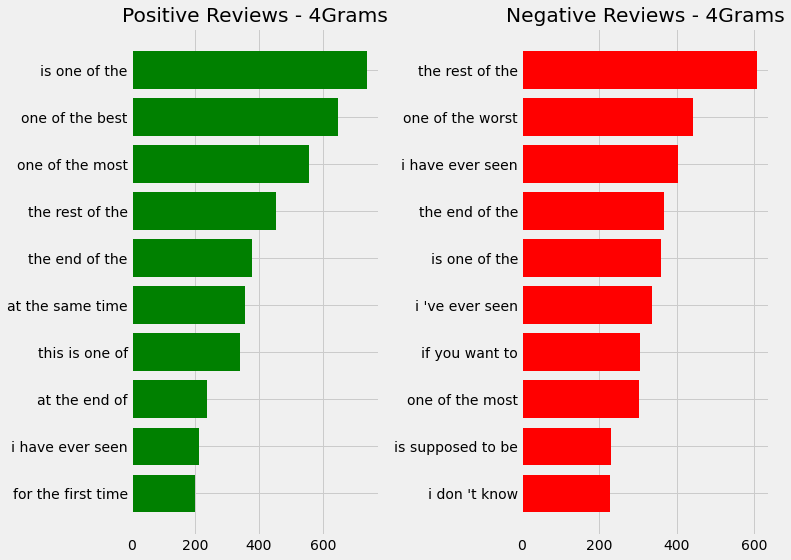

In [121]:
top_n=10
fig,ax =plt.subplots(nrows=1,ncols=2)
ax[0].barh(y=pos_dist.index[:top_n], width=list(pos_dist['Frequency'].iloc[:top_n]),color='green')
ax[0].set_title(f'Positive Reviews - {gram}Grams')
ax[0].invert_yaxis()
ax[1].barh(y=neg_dist.index[:top_n],width=list(neg_dist['Frequency'].iloc[:top_n]),color='red')
ax[1].set_title(f'Negative Reviews - {gram}Grams')
ax[1].invert_yaxis()
fig.tight_layout()

fig.show()

## Word Embedding

In [126]:
# downloading the pre-trained Tensorflow model from tf-hub (model: Token based text embedding trained on English Google News 7B corpus.)
model_loc = "https://tfhub.dev/google/nnlm-en-dim50/2"

In [127]:
# creating tensorflow hub  layer
hub_layer = hub.KerasLayer(model_loc, input_shape=[], dtype=tf.string, trainable=True)


In [128]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [129]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [131]:
x_val = train_examples_processed[:10000]
partial_x_train = train_examples_processed[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [141]:
history = model.fit(np.array(partial_x_train),
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(np.array(x_val), y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 23s 773ms/step - loss: 0.4880 - accuracy: 0.8183 - val_loss: 0.4419 - val_accuracy: 0.8336
Epoch 2/40
30/30 [==============================] - 24s 805ms/step - loss: 0.3613 - accuracy: 0.8773 - val_loss: 0.3553 - val_accuracy: 0.8632
Epoch 3/40
30/30 [==============================] - 20s 661ms/step - loss: 0.2655 - accuracy: 0.9099 - val_loss: 0.3045 - val_accuracy: 0.8772
Epoch 4/40
30/30 [==============================] - 21s 706ms/step - loss: 0.1988 - accuracy: 0.9355 - val_loss: 0.2795 - val_accuracy: 0.8866
Epoch 5/40
30/30 [==============================] - 21s 698ms/step - loss: 0.1525 - accuracy: 0.9533 - val_loss: 0.2702 - val_accuracy: 0.8908
Epoch 6/40
30/30 [==============================] - 19s 621ms/step - loss: 0.1161 - accuracy: 0.9687 - val_loss: 0.2657 - val_accuracy: 0.8938
Epoch 7/40
30/30 [==============================] - 24s 804ms/step - loss: 0.0883 - accuracy: 0.9799 - val_loss: 0.2677 - val_accuracy: 0.8930

In [146]:
results = model.evaluate(np.array(test_examples_processed), test_labels)

print(f"accuracy: {np.round(results[1],3)*100}%")

782/782 [==============================] - 1s 2ms/step - loss: 0.5919 - accuracy: 0.8572
accuracy: 85.7%


In [178]:
test_predictions = model.predict_classes(np.array(test_examples_processed))

/home/nejada/anaconda3/envs/tf_2x/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [179]:
cm=confusion_matrix(test_labels,test_predictions,labels=[0,1])

<AxesSubplot:>

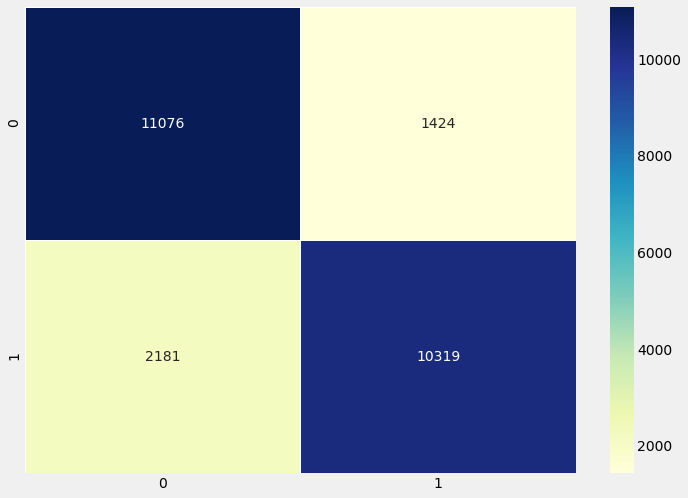

In [181]:
sns.heatmap(cm,annot=True,fmt="d", linewidths=.5,cmap="YlGnBu")